# 2 Semi-supervised VAE

In [509]:
import os

import pyro
import pyro.distributions as D
import pyro.contrib.examples.util 
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as T
from pyro.distributions.util import broadcast_shape

In [510]:
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [511]:
import random

def setup_dataloaders(batch_size=128):
    root = './data/01_vae/'
    download = True
    
    trans = T.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [512]:
def unsupervised_loader(p=0.1):
    train, _ = setup_dataloaders()
    N = int(1 / p) - 1
    Xsup, Ysup = [], []
    Xuns = []
    
    cnt = 0
    for x, y in train:
        x = x.reshape(-1, 784)
        if random.random() < p:
            Xsup.append(x)
            Ysup.append(nn.functional.one_hot(y, num_classes=10))
            cnt += 1
        else:
            Xuns.append(x)           
            
    if abs(cnt - len(train) * p) > 1000 * p or cnt < 1:
        print('-')
        return unsupervised_loader(p)
    return [(x, y) for x, y in zip(Xsup, Ysup)], Xuns

In [513]:
from tqdm import trange

In [514]:
def test_accuracy(loader, classifier):
    predictions, actuals = [], []
    for x, y in loader:
        x = x.reshape(-1, 784)
        predictions.append(classifier(x))
        actuals.append(y.reshape(-1, 1))
    
    accurate = 0   
    for pred, act in zip(predictions, actuals):
        accurate += torch.sum(pred == act).item() / 128
        
    return accurate / len(loader)

In [515]:
class EncoderZ(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784 + 10, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()
        
    def forward(self, x):
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

## First variant: Standar objective function, naive estimator

In [516]:
def train_loop(model, guide, classifier, p=0.1, epochs=100, iters=150, lr=4e-4):
    svi = SVI(model, guide, Adam({'lr':lr}), loss=Trace_ELBO())
    sup_loss = []
    uns_loss = []
    accuracy = []

    train_loader, test_loader = setup_dataloaders()
    SUP, UNS = unsupervised_loader(p)
    for epoch in trange(epochs):
        sup_ = 0
        uns_ = 0
        random.shuffle(UNS)
        random.shuffle(SUP)
        uns = iter(UNS)
        sup = iter(SUP)
        for step in range(iters):
            x, y = next(sup, (None, None))
            if x is None:
                sup = iter(SUP)
                x, y = next(sup)
            sup_ += svi.step(x, y) / 128
            
            x = next(uns, None)
            if x is None:
                uns = iter(UNS)
                x = next(uns)
            uns_ += svi.step(x) / 128
            
        
                
        sup_loss.append(sup_ / iters)
        uns_loss.append(uns_ / iters)
        
        accuracy.append(test_accuracy(test_loader, classifier))
        
    return sup_loss, uns_loss, accuracy
        
        
    

In [517]:
class SSVAE(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=500, enum=False):
        super().__init__()
        self.encoder_y = nn.Sequential(
            nn.Linear(784, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 10),
            nn.Softmax(1)
        )
        
        self.encoder_z = EncoderZ(z_dim, hidden_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(10 + z_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 784),
            nn.Sigmoid()
        )
        self.z_dim = z_dim
        self.enum = enum
        self.aux_loss_multiplier = 46
        
    def model(self, x:torch.Tensor, y:torch.Tensor=None):
        pyro.module('ss_vae', self)
        batch_size = x.size(0)
        
        with pyro.plate('data'):
            prior_loc = x.new_zeros(batch_size, self.z_dim)
            prior_scale = x.new_ones(batch_size, self.z_dim)
            z = pyro.sample('z', D.Normal(prior_loc, prior_scale).to_event(1))
            
            alpha_prior = x.new_ones(batch_size, 10) / 10. 
            y = pyro.sample('y', D.OneHotCategorical(alpha_prior), obs=y)
            input_args = [z, y]
            if self.enum:
                input_args = SSVAE.concat(input_args)
            input_args = torch.cat(input_args, dim=-1)
            loc = self.decoder(input_args)
            pyro.sample('x', D.Bernoulli(loc).to_event(1), obs=x)
            return loc 
            
        
    def guide(self, x:torch.Tensor, y:torch.Tensor=None):
        with pyro.plate('data'):
            if y is None:
                alpha = self.encoder_y(x)
                y = pyro.sample('y', D.OneHotCategorical(alpha))
                
            input_args = [x, y]
            if self.enum:
                input_args = SSVAE.concat(input_args)
            input_args = torch.cat(input_args, dim=-1)
            
            loc, scale = self.encoder_z(input_args)
            pyro.sample('z', D.Normal(loc, scale).to_event(1))
            
    def classifier(self, x:torch.Tensor):
        alpha = self.encoder_y(x)
        res, ind = torch.topk(alpha, 1)
        # y = torch.zeros_like(alpha).scatter(1, ind, 1.)
        return ind
    
    def model_classify(self, x:torch.Tensor, y:torch.Tensor=None):
        pyro.module('ss_vae', self)
        
        with pyro.plate('data'):
            if y is not None:
                alpha = self.encoder_y(x)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", D.OneHotCategorical(alpha), obs=y)
                    
    def guide_classify(self, x, y=None):
        pass
    
    def concat(args):
        shape = broadcast_shape(*[s.shape[:-1] for s in args]) + (-1,)
        input_args = [s.expand(shape) for s in args]
        return input_args
                    
        

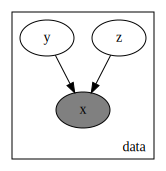

In [518]:
pyro.render_model(SSVAE().model, (torch.ones(2, 784), ))

In [519]:
ps = [0.1, 0.05, 0.01, 0.002]
sups, unss, accs = [], [], []

for p in ps[::-1]:
    pyro.clear_param_store()
    model = SSVAE()
    sup, uns, acc = train_loop(model.model, model.guide, model.classifier, p=p, epochs=750, iters=150, lr=4e-4)
    sups.append(sup)
    unss.append(uns)
    accs.append(acc)

-


100%|██████████| 750/750 [1:40:13<00:00,  8.02s/it]


In [520]:
import matplotlib.pyplot as plt 

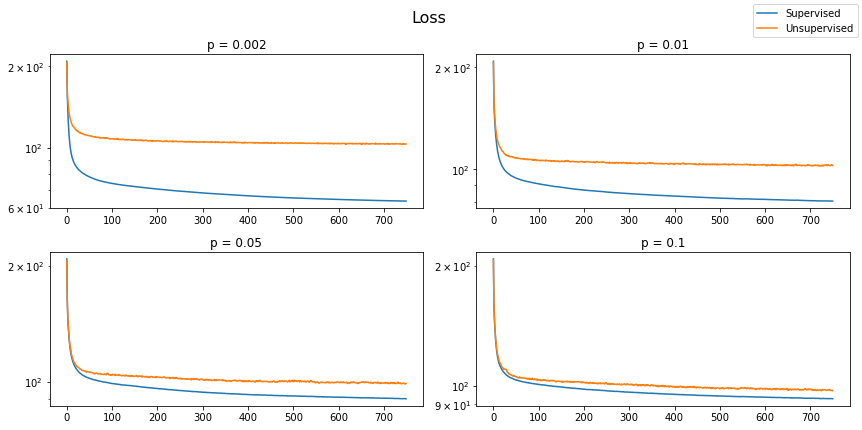

In [521]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for k in range(4):
    ax = axes[k // 2][k % 2]
    ax.plot(sups[k], label='Supervised')
    ax.plot(unss[k], label='Unsupervised')
    ax.set(title=f'p = {ps[-(k+1)]}')
    ax.set(yscale='log')
    
plt.suptitle('Loss', fontsize=16)
h, l = ax.get_legend_handles_labels()
plt.figlegend(h, l)
plt.tight_layout()
plt.show()
plt.close()

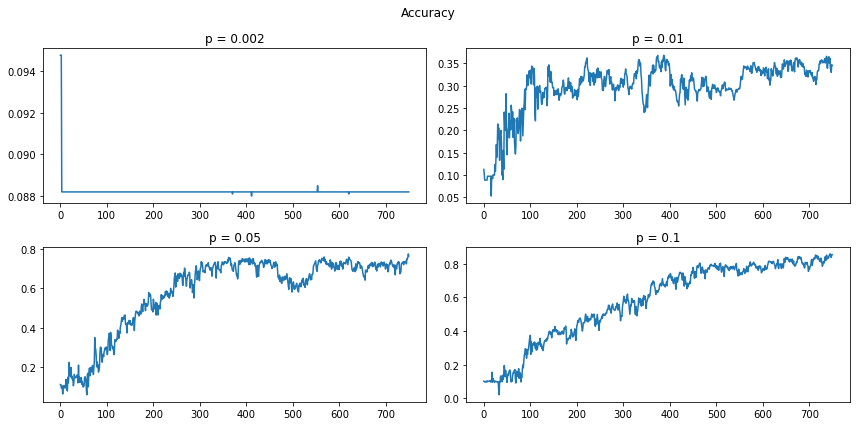

In [522]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for k in range(4):
    ax = axes[k // 2][k % 2]
    ax.plot(accs[k])
    ax.set(title=f'p = {ps[-(k+1)]}')
    
plt.suptitle('Accuracy')
plt.tight_layout()
plt.show()
plt.close()

## Second Variant: Standar Objective Function, Better Estimator

In [523]:
from pyro.infer import config_enumerate

In [524]:
def train_loop(model, guide, classifier, p=0.1, epochs=100, iters=150, lr=4e-4):
    svi = SVI(model, config_enumerate(guide, 'parallel', expand=True), Adam({'lr':lr}), 
              TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False))
    sup_loss = []
    uns_loss = []
    accuracy = []

    train_loader, test_loader = setup_dataloaders()
    SUP, UNS = unsupervised_loader(p)
    for epoch in trange(epochs):
        sup_ = 0
        uns_ = 0
        random.shuffle(UNS)
        random.shuffle(SUP)
        uns = iter(UNS)
        sup = iter(SUP)
        for step in range(iters):
            x, y = next(sup, (None, None))
            if x is None:
                sup = iter(SUP)
                x, y = next(sup)
            sup_ += svi.step(x, y) / 128
            
            x = next(uns, None)
            if x is None:
                uns = iter(UNS)
                x = next(uns)
            uns_ += svi.step(x) / 128
            
        
                
        sup_loss.append(sup_ / iters)
        uns_loss.append(uns_ / iters)
        
        accuracy.append(test_accuracy(test_loader, classifier))
        
    return sup_loss, uns_loss, accuracy

In [525]:
ps = [0.1, 0.05, 0.01, 0.002]
sups, unss, accs = [], [], []

for p in ps[::-1]:
    pyro.clear_param_store()
    model = SSVAE(enum=True)
    sup, uns, acc = train_loop(model.model, model.guide, model.classifier, p=p, epochs=500, iters=150, lr=4e-4)
    sups.append(sup)
    unss.append(uns)
    accs.append(acc)

100%|██████████| 500/500 [2:44:32<00:00, 19.75s/it]  


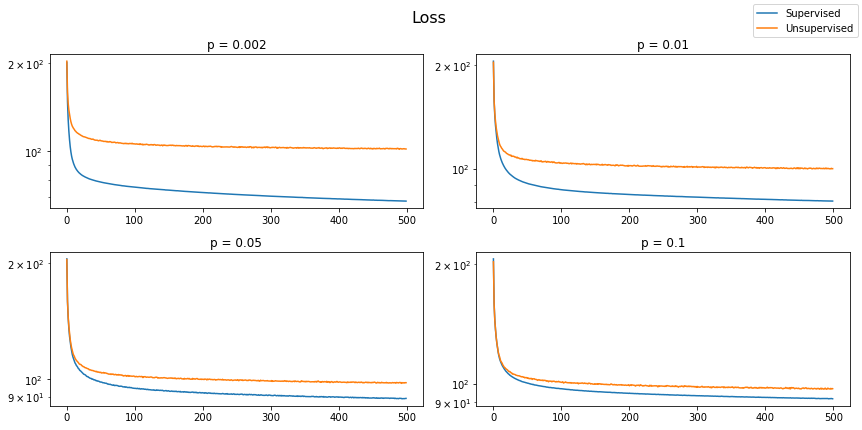

In [526]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for k in range(4):
    ax = axes[k // 2][k % 2]
    ax.plot(sups[k], label='Supervised')
    ax.plot(unss[k], label='Unsupervised')
    ax.set(title=f'p = {ps[-(k+1)]}')
    ax.set(yscale='log')
    
plt.suptitle('Loss', fontsize=16)
h, l = ax.get_legend_handles_labels()
plt.figlegend(h, l)
plt.tight_layout()
plt.show()
plt.close()

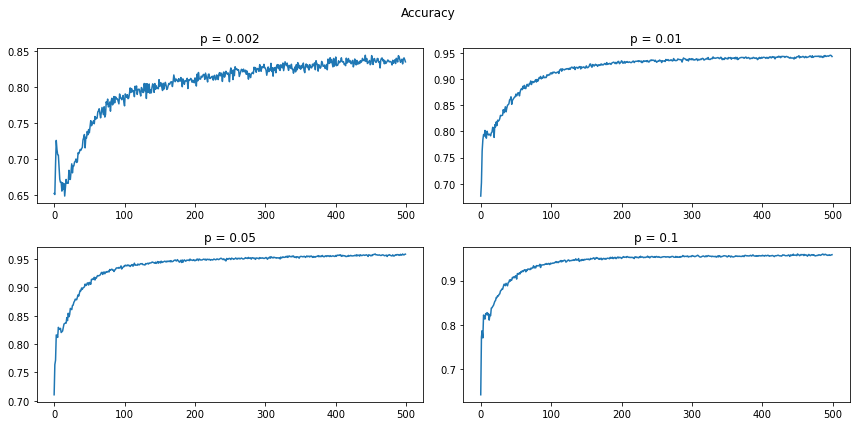

In [527]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for k in range(4):
    ax = axes[k // 2][k % 2]
    ax.plot(accs[k])
    ax.set(title=f'p = {ps[-(k+1)]}')
    
plt.suptitle('Accuracy')
plt.tight_layout()
plt.show()
plt.close()

## Third Variant: Adding a Term to the Objective

In [528]:
def train_loop(model, guide, classifier, aux_model, aux_guide,
               p=0.1, epochs=100, iters=150, lr=4e-4):
    svi = SVI(model, config_enumerate(guide, 'parallel', expand=True), Adam({'lr':4e-4}), 
              TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False))
    aux_svi = SVI(aux_model, aux_guide, Adam({'lr':lr}), Trace_ELBO())
    
    sup_loss = []
    uns_loss = []
    aux_loss = []
    accuracy = []

    train_loader, test_loader = setup_dataloaders()
    SUP, UNS = unsupervised_loader(p)
    for epoch in trange(epochs):
        sup_ = 0
        uns_ = 0
        aux_ = 0
        random.shuffle(UNS)
        random.shuffle(SUP)
        uns = iter(UNS)
        sup = iter(SUP)
        for step in range(iters):
            x, y = next(sup, (None, None))
            if x is None:
                sup = iter(SUP)
                x, y = next(sup)
            sup_ += svi.step(x, y) / 128
            aux_ += aux_svi.step(x, y) / 128
            
            x = next(uns, None)
            if x is None:
                uns = iter(UNS)
                x = next(uns)
            uns_ += svi.step(x) / 128
            aux_ += svi.step(x) / 128
            
        
                
        sup_loss.append(sup_ / iters)
        uns_loss.append(uns_ / iters)
        aux_loss.append(aux_ / (2 * iters))
        
        accuracy.append(test_accuracy(test_loader, classifier))
        
    return sup_loss, uns_loss, aux_loss, accuracy

In [530]:
ps = [0.1, 0.05, 0.01, 0.002]
sups, unss, auxs, accs = [], [], [], []

for p in ps[::-1]:
    pyro.clear_param_store()
    model = SSVAE(enum=True)
    sup, uns, aux, acc = train_loop(model.model, model.guide, model.classifier, model.model_classify, model.guide_classify,
                                    p=p, epochs=250, iters=150, lr=4e-4)
    sups.append(sup)
    unss.append(uns)
    auxs.append(aux)
    accs.append(acc)

100%|██████████| 250/250 [2:25:35<00:00, 34.94s/it]  


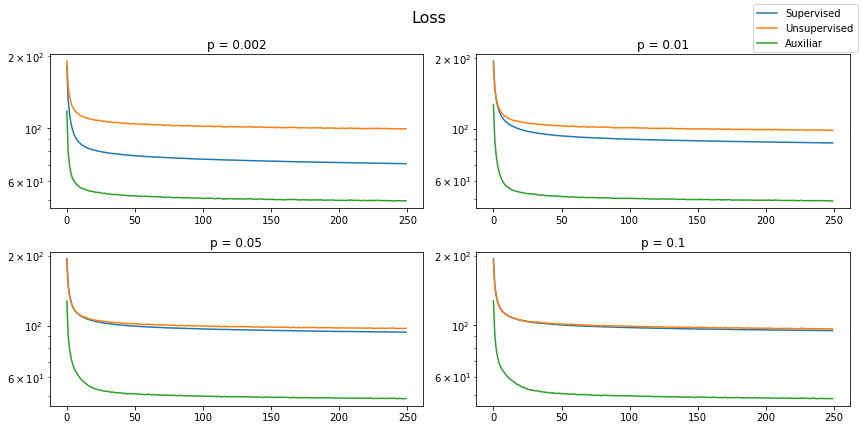

In [531]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for k in range(4):
    ax = axes[k // 2][k % 2]
    ax.plot(sups[k], label='Supervised')
    ax.plot(unss[k], label='Unsupervised')
    ax.plot(auxs[k], label='Auxiliar')
    ax.set(title=f'p = {ps[-(k+1)]}')
    ax.set(yscale='log')
    
plt.suptitle('Loss', fontsize=16)
h, l = ax.get_legend_handles_labels()
plt.figlegend(h, l)
plt.tight_layout()
plt.show()
plt.close()

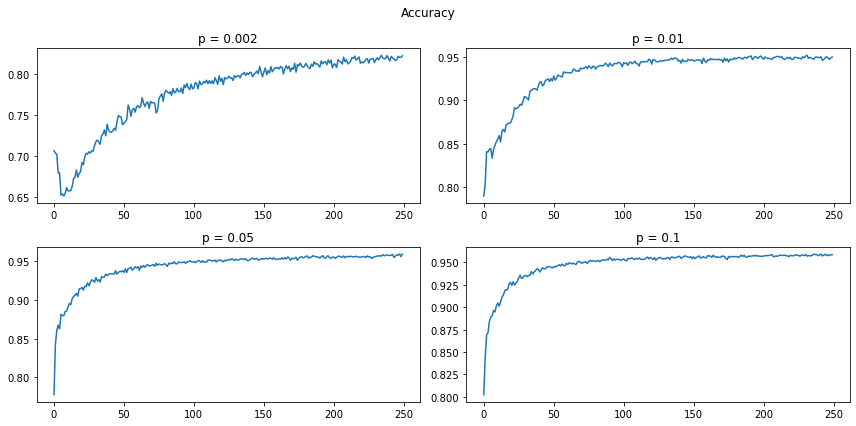

In [532]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for k in range(4):
    ax = axes[k // 2][k % 2]
    ax.plot(accs[k])
    ax.set(title=f'p = {ps[-(k+1)]}')
    
plt.suptitle('Accuracy')
plt.tight_layout()
plt.show()
plt.close()

In [533]:
def plot_conditional_samples(model):
    result = []
    ys = [nn.functional.one_hot(torch.tensor([n]), num_classes=10) for n in range(10)]
    
    for y in ys:
        y = y.expand(16, 10)
        x = torch.zeros(16, 784)
        result.append(model(x, y).view(-1, 28, 28))
        
    trans = T.ToPILImage()   
    
    plt.figure(figsize=(16, 10))
    for i in range(10):
        imgs = result[i]
        for k in range(imgs.size(0)):
            plt.subplot(10, 16, i*16 + k+1)
            plt.imshow(trans(imgs[k]), cmap='gray')
            plt.axis('off')
            
            
    plt.suptitle('Conditional generations', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

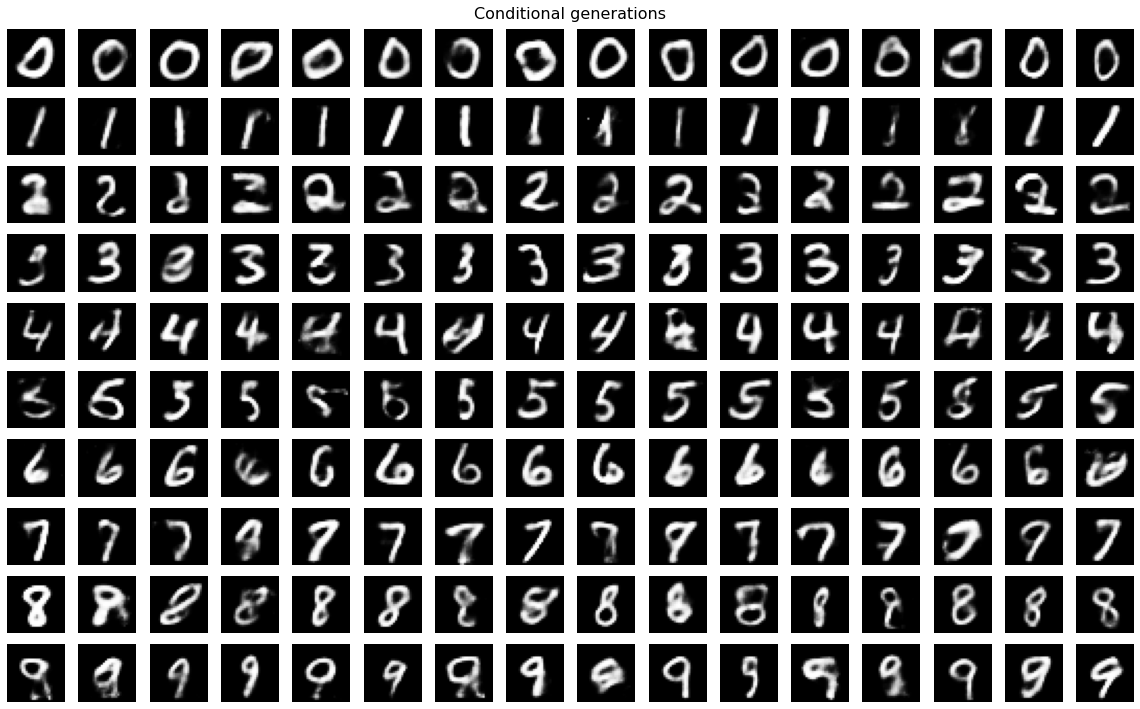

In [534]:
plot_conditional_samples(model.model)